# Compare `linear` and `circular` options for finding PIV correlations.

This tutorial is inspired by the discussion in OpenPIV Google groups dated by 5th of July 2024 (here is the link: https://groups.google.com/g/openpiv-users/c/qWvjyzEY-JA/m/1FcgN9MeAwAJ).

The underline OpenPIV function - the one that actually calculates PIV correlations - is `pyprocess.fft_correlate_images()`. Among others, it has two arguments: `correlation_method` that assumes the values of either `circular` or `linear` and `normalized_correlation` that assumes the values of either `True` or `False`. This notebook explores the effect of these two arguments. Note, that there already exists an OpenPIV tutorial notebook going into the depth of the difference between `linear` and `circular` fft methods - that notebook is called `studying_correlations.ipynb`. In turn, the current notebook aims to compare the two methods on a real dataset.

Here is the quote from Dr. Liberzon's answer in OpenPIV Google groups describing the difference between `circular` and `linear` fft methods of finding PIV correlations.

> Cross-correlation basic definition we use is called 'direct cross-correlation,' and it is defined in the space domain. We take two finite signals, A and B, each of length N (let's say a single row of intensity values in the image) and shift B over A from left to right such that the first B touches that A from the left 1 pixel, so the shift is -N and then shifts and overlaps completely (zero shift) and to the right to the last pixel touches A - +N. At each shift, we multiply the intensity of overlapped regions between part of A and part of B and get a value of cross-correlation. The result is a signal of 2N-1 length. if we do it A with A we get correlation and obviously the highest value will be at the shift = 0, i.e. complete overlap. This animation is great, thanks to Zhigunov
https://commons.wikimedia.org/wiki/File:Cross_Correlation_Animation.gif

>You can find this algorithm in OpenPIV here: 
```
    elif correlation_method == 'direct':
        return convolve2d(normalize_intensity(window_a),
                          normalize_intensity(window_b[::-1, ::-1, ::-1]), 'full')
    else:
        raise ValueError("method is not implemented")
```

>As you see, we eventually dropped it out because it is slower than the FFT-based ones. Its definition is rather clear in Scipy correlate

>https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html

>Maybe we need to learn from Scipy how to choose automatically which method is faster. But the general agreement that FFT-based ones are faster. 

>When the PIV community moved to FFT-based correlations, it becomes clear that the FFT based cross-correlation is a sort of "periodic" or "circular" assumption, i.e. the finite signal of length N is presumably periodic and will repeat itself again and again. Sort of imagine one interrogation window repeats itself over 32 pixels again and again. In this case the circular method, i.e. using the original signal of length N and creating a result of 2N-1 will give the correct result. The proof of this is out of the scope of this answer, I recommend the book, but you can find it here also: 

>http://www.learnpiv.org/fft/

>So, to adjust the FFT-based correlation algorithm to the finite length non-periodic interrogation windows, the signal processing community suggests to pad zeros of at least length N on each side of the window - this means that the basic "period" is much longer and the inner (middle) part is our signal and then the FFT-based will correctly represent the shift close to the center of the window, less than 1/2 of window  size and will tame down the high frequencies coming from the edges of the window (due to non-periodicity of these finite windows). So linear one is the same formula as the circular one, but with zero-padded windows

>Erich Zimmer asked to add both algorithms to the OpenPIV - he claimed that in some cases circular is faster (smaller windows) and if the shift is not too large, then maybe circular can be even more accurate. In the original OpenPIV (in Matlab and Python) we had only zero-padded version - as Raffel's book recommends. 

>You can find the discussion here: 
>https://github.com/OpenPIV/openpiv-python/pull/208

In the current notebook, we are going to use a difficult PIV case of an upward cap-bubbly air-water two-phase flow and see what velocity field we get with different methods.

In [1]:
import pathlib
import cv2 # conda install opencv; alternatively use imread() from openpiv tools
import numpy as np
import matplotlib.pyplot as plt
from openpiv import tools, pyprocess, preprocess, validation, filters, scaling

Now let's write a function that does basic PIV processing on a pair of PIV frames. The function will calculate correlations with `pyprocess.fft_correlate_images()`, then it will convert correlations to displacements with `pyprocess.correlation_to_displacement` and, finally, it will validate the velocity field and replace the outliers. You will see that different correlation methods result in 1) different signal to noise threshold values, 2) the range of values in which one can change the treshold value and, still, obtain reasonably good velocity field.

Note that different magnitudes of signal to noise ratio thresholds for different methods are expected. Here is the quote from Dr. Liberzon.

>There is no single value that can be used to threshold invalid vectors. This is because different correlation methods provide different values of correlation maps (the result of cross-correlation as explained in the following answer) and different definitions: peak to peak or peak to mean. Therefore, changing the correlation method or the S/N ratio definition will create a new distribution of values for a given image pair or set. I suggest always running the small subset of images, creating a histogram of S2N values, and then choosing a threshold that separates less and more suspicious vectors. BTW, these vectors LOOK GOOD most of the time, so the high or low S2N is not yet a definition of an invalid vector. 

>I recommend the book by Raffel. It contains everything one needs to know about PIV, at least in the context of OpenPIV. 

>This quick source that I found is reasonably correct https://arxiv.org/pdf/1405.3023

In [2]:
def PIVanalysis(dataArray, 
                imageShape, 
                searchAreaSize,
                overlap,
                scalingFactor,
                deltaT,
                maskBubble,
                nameTXT,
                normalizedCorrelation,
                correlationMethod,
                onImg = None,
                s2nThresh = 0.8                
               ):
    
    """
    The procedure is adapted from ensemble_correlation.ipynb OpenPIV tutorial.
    Parameters: dataArray (numpy array) - an array of PIV images that contains only
                                          one PIV pair, its structure is
                                          dataArray = np.asarray([frameA, frameB])
                onImg (cv2.imread) - an image to plot the velocity fields on 
                searchAreaSize (int) - is the size of the interrogation window on frameB;
                                       it can be a bit bigger, which, reportedly, is better
                                       for PIV pair with high dynamic range (like in our
                                       case, where velocities in the bubble wake are much
                                       bigger than velocities closer to the walls of the test section -
                                       the range of velocities (i.e., dynamic range) is big)
                maskBubble (numpy array) - a binary image where bubbles are white and background is
                                           black; is used to mask out bubbles
                deltaT (float) - s, the time between the two PIV frames
                scalingFactor (float) - pix/mm, scaling factor
                nameTXT (str) - .txt, the name of the file to save the resultant OpenPIV velocity field
                normalizedCorrelation (bool) - can be True or False, this is a parameter in
                                               pyprocess.fft_correlate_images() function
                correlationMethod (str) - can be "circular" or "linear", this is a parameter in
                                          pyprocess.fft_correlate_images() function
    Returns: None
    """
    # Mask out the bubbles.
    dataArray[0] = cv2.bitwise_and(dataArray[0], dataArray[0], mask=cv2.bitwise_not(maskBubble))
    dataArray[1] = cv2.bitwise_and(dataArray[1], dataArray[1], mask=cv2.bitwise_not(maskBubble))

    # Find the correlations map.
    # "linear" correlation_method together with normalized_correlation=True
    # helps to boost the s2n threshold from 1.003 to 2 for 95% valid vectors.
    corrs = pyprocess.fft_correlate_images(
        pyprocess.moving_window_array(dataArray[0],searchAreaSize,overlap),
        pyprocess.moving_window_array(dataArray[1],searchAreaSize,overlap),
        normalized_correlation=normalizedCorrelation,
        correlation_method=correlationMethod
    )
    
    mesh = pyprocess.get_field_shape(imageShape,
                                     search_area_size = searchAreaSize,
                                     overlap = overlap
    )

    nrows, ncols = mesh[0], mesh[1]
    
    # Having found correlations, we can find corresponding displacements in pix.
    # IMPOTANT: OpenPIV uses u and v for displacements as well as for velocities in
    # Since that's confusing, we are going to use xDisp and yDisp for 
    # displacements and u and v for velocities.
    xDisp, yDisp = pyprocess.correlation_to_displacement(corrs, nrows, ncols)

    # Having found displacements in pix, we can find corresponding velocities in
    # pix/time
    u = xDisp/deltaT # pix/s
    v = yDisp/deltaT # pix/s

    x, y = pyprocess.get_coordinates(imageShape,
                                     search_area_size = searchAreaSize,
                                     overlap = overlap
    )

    # Mask out the areas without the flow right now (bubbles).
    grid_mask = preprocess.prepare_mask_on_grid(x, y, maskBubble[:,::-1])
    masked_u = np.ma.masked_array(u, mask=grid_mask)
    masked_v = np.ma.masked_array(v, mask=grid_mask)

    # Now let's do validation. Pay attention, that validation doesn't mean automatic
    # replacement of the outliers, it means that we are going to detect the outliers
    # and mark them as outliers. Their replacement is a separate procedure and will
    # be done next.

    # Do the validation of the correlation peaks.
    corrs = corrs.astype('float64')
    s2n = pyprocess.sig2noise_ratio(corrs, "peak2mean")
    invalid_mask_s2n = validation.sig2noise_val(s2n, threshold = s2nThresh)

    # Now we can replace outliers flagged by the invalid_mask_s2n.
    masked_u, masked_v = filters.replace_outliers(masked_u.flatten(), masked_v.flatten(),
                                                  invalid_mask_s2n,
                                                  method = 'localmean',
                                                  max_iter = 3, 
                                                  kernel_size = 17 
    ) # IMPORTANT to flatten u and v
    
    x, y, masked_u, masked_v = scaling.uniform(x, y, masked_u, masked_v, scaling_factor = scalingFactor)

    # MASK OUT VELOCITY FIELD.
    # Before saving the field to a .txt file, give zeros to those vectors that lie in the masked regions.
    # Right now, x and y are in the image system of coordinates: x is to the right, y is downwards, (0,0)
    # is in the top left corner. It can be learnt from the GitHub code of tools.transform_coordinates.
    # Since our x and y are in mm, we're going to use scaling factor to convert them to pix. Then we're going
    # to use them to identify whether or not their place on an example masked image is masked.
    xFlat = x.flatten()
    yFlat = y.flatten()
    for i in range(xFlat.size):
        if maskBubble[int(yFlat[i]*scalingFactor), int(xFlat[i]*scalingFactor)] == 255:
                masked_u[i] = 0
                masked_v[i] = 0
    
    x, y, masked_u, masked_v = tools.transform_coordinates(x, y, masked_u, masked_v)

    tools.save(nameTXT, x, y, masked_u, masked_v, invalid_mask_s2n)
    
    
    # Calculate the percentage of the invalid vectors due to sig2noise validation.
    invSnrOutPer = (np.count_nonzero(invalid_mask_s2n) / invalid_mask_s2n.size) * 100 # percent of the invalid vectors
    print("\nPercentage of invalid vectors due to signal to noise ratio validation: {:.2f}.".format(invSnrOutPer))
    print("\nThe resultant velocity field (red are vectors that were validated as outliers\nand replaced with the average of their neighbouring vectors):")
    figure, _ = tools.display_vector_field(filename = str(nameTXT),
                                           scaling_factor = scalingFactor,
                                           scale = 3500,
                                           on_img = True,
                                           show_invalid = True,
                                           image_name = onImg
    )
    plt.show()

In [3]:
# Global variables
tPulse = 0.0015 # s - time between frame A and frame B
ol = 16 # overlap: give it in pix, not %
interW = 32 # the size of the interrogation window
searchAS = np.round(1.1*interW).astype(np.uint32) # the size of the interrogation window in frameB 
sf = 1/0.052 # pix/mm scaling factor

# The name of the OpenPIV txt file to save the results to.
fileTXT = '../test21/bubblesLinearCircular.txt'

# The file names of PIV frames and bubbles mask.
frameA = '../test21/bubblesFrameA.png'
frameB = '../test21/bubblesFrameB.png'
bubblesMaskFile = '../test21/bubblesMask.png'

pairPIV = np.asarray([cv2.imread(frameA,0), cv2.imread(frameB,0)]) # 0 flag means read as gray scale
bubblesMask = cv2.imread(bubblesMaskFile,0) # 0 flag means read as gray scale
imageShape = pairPIV[0].shape

Let's start with **linear normalized correlation**.

linear correlation, normalized:


Percentage of invalid vectors due to signal to noise ratio validation: 5.03.

The resultant velocity field (red are vectors that were validated as outliers
and replaced with the average of their neighbouring vectors):


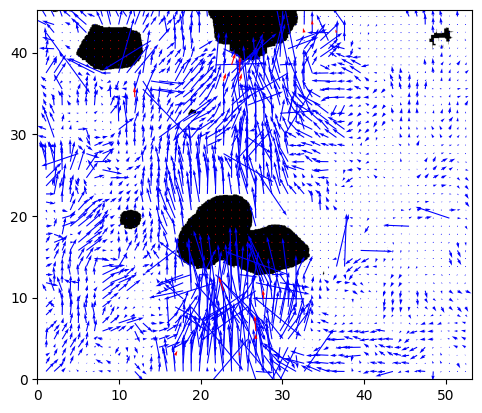

In [4]:
# According to the comments given in the body of pyprocess.fft_correlate_images() function,
# linear correlation must be normalized. So, we are going to explore only linear normalized option.
# I.e., we are not going to do linear not normalized option.
print("linear correlation, normalized:\n")
PIVanalysis(dataArray = pairPIV, 
            imageShape = imageShape, 
            searchAreaSize = searchAS,
            overlap = ol,
            scalingFactor = sf,
            deltaT = tPulse,
            maskBubble = bubblesMask,
            nameTXT = fileTXT,
            normalizedCorrelation = True,
            correlationMethod = 'linear',
            s2nThresh = 2, 
            onImg = bubblesMaskFile                 
)

You can notice that, in the case of linear normalized correlation method, we are dealing with relatively high values of signal to noice ratios because the signal to noise threshold we used was s2nThresh = 2. That's a pretty good threshold. I.e., linear correlation method produces nice correlations and we can have a lot of correlations peak at least 2 times bigger than their respective averages. Go ahead and play with the s2nThresh parameter above. You will see that you can go up to s2nThresh = 5 and, still, get the visually correct velocity field.

Now, let's do **circular not normalized correlation**.

circular correlation, not normalized:


Percentage of invalid vectors due to signal to noise ratio validation: 10.65.

The resultant velocity field (red are vectors that were validated as outliers
and replaced with the average of their neighbouring vectors):


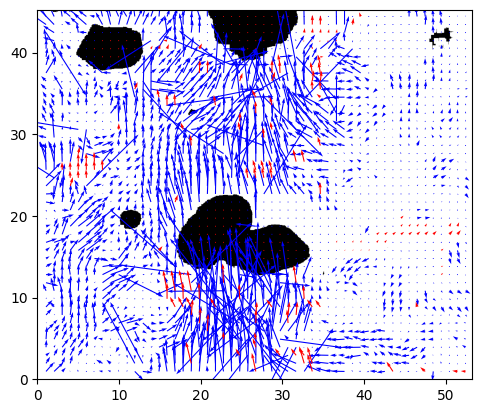

In [5]:
print("circular correlation, not normalized:\n")
PIVanalysis(dataArray = pairPIV, 
            imageShape = imageShape, 
            searchAreaSize = searchAS,
            overlap = ol,
            scalingFactor = sf,
            deltaT = tPulse,
            maskBubble = bubblesMask,
            nameTXT = fileTXT,
            normalizedCorrelation = False,
            correlationMethod = 'circular',
            s2nThresh = 1.05, 
            onImg = bubblesMaskFile                 
)

You can notice that, in the case of circular not normalized correlation method, we are dealing with relatively low values of signal to noice ratios because the signal to noise threshold we used was s2nThresh = 1.05. That's a rather bad threshold. I.e., we keep the correlation peaks which are only 5% larger than their respective averages. That's not a good threshold to distinguish valid signal from noise. Go ahead play with the parameter s2nThresh and you will see that you can't go above s2nThresh = 1.11 (where the velocity field starts looking unphysical). In other words, circular not normalized method produces correlations with peaks barealy distingyishable from the noise of the background. I.e., this method doesn't give us a good signal.

Now let's try **circular normalized method**.

circular correlation, normalized:


Percentage of invalid vectors due to signal to noise ratio validation: 12.70.

The resultant velocity field (red are vectors that were validated as outliers
and replaced with the average of their neighbouring vectors):


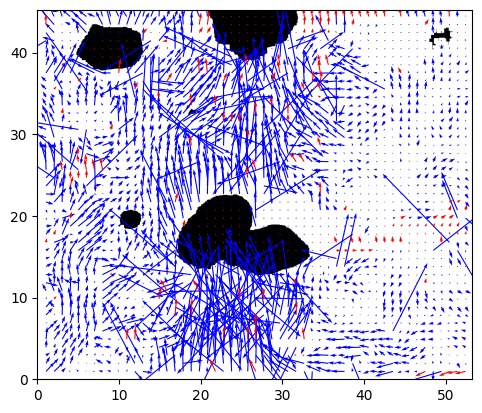

In [6]:
print("circular correlation, normalized:\n")
PIVanalysis(dataArray = pairPIV, 
            imageShape = imageShape, 
            searchAreaSize = searchAS,
            overlap = ol,
            scalingFactor = sf,
            deltaT = tPulse,
            maskBubble = bubblesMask,
            nameTXT = fileTXT,
            normalizedCorrelation = True,
            correlationMethod = 'circular',
            s2nThresh = 2, 
            onImg = bubblesMaskFile                 
)

You can notice that, in the case of circular normalized correlation method, we are dealing with large values of signal to noice ratios because the signal to noise threshold we used was s2nThresh = 2. That's a good threshold. I.e., we keep the correlation peaks which are 20% larger than their respective averages. This is very nice: if the peak is 20% larger than the background noise, we have a valid signal indeed! Go ahead play with the parameter s2nThresh and you will see that you can't go above s2nThresh = 3 (where the velocity field starts looking unphysical). Compare that to linear normalized method above where we could go up to s2nThresh = 5. In other words, circular normalized method produces correlations with peaks easily distingyishable from the noise of the background. I.e., this method gives us a good signal. But not as good as the signal we could obtain from linear normalized method where we could assign a threshold of s2nThresh = 5 and, still, get a legible velocity field.

**Conclusion**: linear normalized method is the winner. It gives the best PIV correlation signal which can be easily thresholded to get rid of outliers. It makes sense, because - as was discussed at the beginning of this notebook - linear normalized method was specifically developed for general PIV applications.

### Final note.

As it was discussed at the beginning of this notebook, the only difference between the formulas for `linear` and `circular` fft correlation methods is that the former has zero padding.

Dr. Liberzon asked ChatGPT to explain the importance of zero padding and create a little python example using OpenPIV. Below is what Dr. Liberzon received in response.

*Note that ChatGPT confirms our conclusions: linear (and normalized) method produces the best signal where the peaks can be identified in the easiest manner.*


Zero-padding is a common technique used before performing FFT-based cross-correlation to improve the accuracy and interpretability of the results. Here's an explanation of why zero-padding is important:

### Purpose of Zero-Padding

1. **Increase Resolution in the Frequency Domain**:
   - **Interpolation**: Zero-padding the signal before taking the FFT increases the number of points in the FFT result, effectively interpolating the frequency spectrum. This helps achieve finer resolution in the frequency domain, making it easier to identify the peak correlation more accurately.
   - **More Accurate Peak Detection**: With higher resolution, the position of the peak in the cross-correlation function can be determined more precisely, which is particularly important for accurate time delay estimation.

2. **Avoid Circular Convolution Artifacts**:
   - **Linear Convolution**: In FFT-based cross-correlation, the use of FFT inherently assumes circular convolution. Zero-padding helps to mitigate the circular convolution artifacts, making the result more representative of the true linear convolution. This is because zero-padding effectively separates the instances of the signals, avoiding overlap that can cause spurious correlations.
   - **Signal Separation**: By padding with zeros, the effective length of the signals is increased, ensuring that the end of one signal does not interfere with the start of the other, which can distort the cross-correlation result.

3. **Handling Boundary Effects**:
   - **Reducing Edge Effects**: Zero-padding helps to reduce edge effects by adding extra space around the signal. This ensures that the FFT does not wrap around the edges of the signal, which can introduce artifacts and distortions in the cross-correlation computation.


### Demonstration with OpenPIV-Python

Let's demonstrate the effect of zero-padding in FFT-based cross-correlation using OpenPIV-Python. We'll perform cross-correlation on a pair of signals with and without zero-padding.

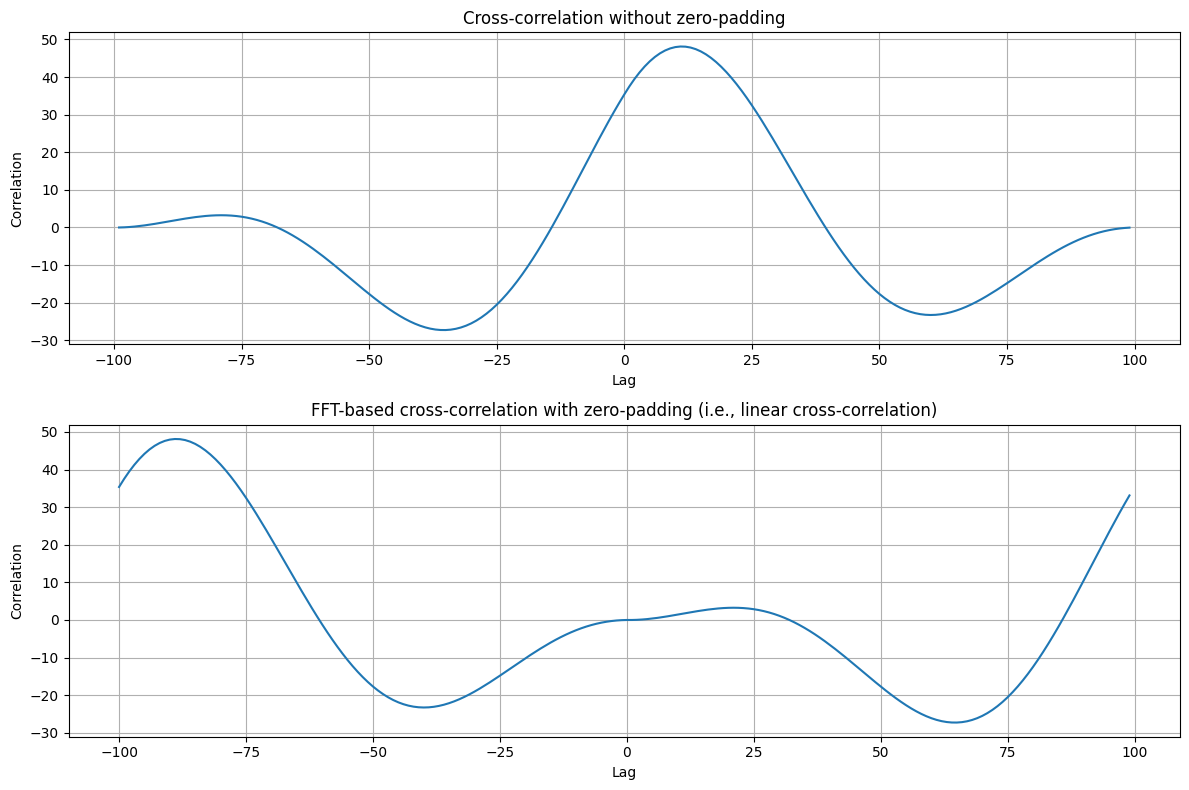

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Create example signals
N = 100  # Number of samples
t = np.linspace(0, 1, N, endpoint=False)
f = np.sin(2 * np.pi * t)  # Sine wave
g = np.sin(2 * np.pi * t + np.pi / 4)  # Phase-shifted sine wave

# Compute cross-correlation without zero-padding the "old-school way".
# The function correlate() below doesn't use fft to calculate correlations. It was the
# original function used in OpenPIV. It was deemed slow and was abandoned and replaced with
# fft-based function. Still, it doesn't do any padding and is a good example of how 
# to work with it.
linear_corr = correlate(f, g, mode='full')

# Zero-pad the signals
padding_length = N
f_padded = np.pad(f, (0, padding_length), 'constant')
g_padded = np.pad(g, (0, padding_length), 'constant')

# Compute FFT-based cross-correlation with zero-padding. Note that we are not using 
# OpenPIV native fft function. But np.fft.ifft() function used below is at the core
# of OpenPIV implementation of fft correlations. OpenPIV implementation is much more
# difficult. So, this is a nice example convaying the core idea without additional
# complications.
f_fft = np.fft.fft(f_padded)
g_fft = np.fft.fft(g_padded)
circular_corr = np.fft.ifft(f_fft * np.conj(g_fft)).real

# Generate lag arrays
lags_linear = np.arange(-N + 1, N)
lags_circular = np.arange(-N, N)

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(lags_linear, linear_corr)
plt.title('Cross-correlation without zero-padding')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(lags_circular, circular_corr)
plt.title('FFT-based cross-correlation with zero-padding (i.e., linear cross-correlation)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid()

plt.tight_layout()
plt.show()

### Observations
- **A note to ChatGPT's observastions from the author of this notebook**: Look at the plots above: the signal at zero is much better when classical correlation() function was used. FFT has inferior signal at zero and "artifacts" at the edges. So in this example, the classical correlation() function is superior. But since FFT is faster, we use it nonetheless. Also pay attention that OpenPIV's implementation of fft correlations is much more intricate and better tested than this simplistic little ChatGPT example. The following is what we were supposed to conclude...
- **Without Zero-Padding**: The linear cross-correlation without zero-padding might have lower resolution and could suffer from edge effects, making it harder to accurately determine the peak correlation.
- **With Zero-Padding**: The FFT-based cross-correlation with zero-padding provides higher resolution and mitigates circular convolution artifacts, leading to more accurate and interpretable results.

### Conclusion
Zero-padding before FFT-based cross-correlation is crucial for achieving higher resolution in the frequency domain, avoiding artifacts from circular convolution, and reducing boundary effects. This practice ensures more accurate and reliable cross-correlation results, which is particularly important in applications requiring precise time delay estimation and signal analysis.